使用R语言处理回归中的自相关情形。

先以冰淇淋数据集为例：

In [2]:
library(haven)
library(tidyverse)
icecream <- read_dta("stata_data/icecream.dta")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the ]8;;http://conflicted.r-lib.org/conflicted package]8;; to force all conflicts to become errors


In [127]:
icecream

# A tibble: 30 × 6
    time consumption price income  temp temp100
   <dbl>       <dbl> <dbl>  <dbl> <dbl>   <dbl>
 1     1       0.386 0.270     78    41   0.410
 2     2       0.374 0.282     79    56   0.560
 3     3       0.393 0.277     81    63   0.630
 4     4       0.425 0.280     80    68   0.680
 5     5       0.406 0.272     76    69   0.690
 6     6       0.344 0.262     78    65   0.650
 7     7       0.327 0.275     82    61   0.610
 8     8       0.288 0.267     79    47   0.470
 9     9       0.269 0.265     76    32   0.320
10    10       0.256 0.277     79    24   0.240
# ℹ 20 more rows
# ℹ Use `print(n = ...)` to see more rows

# 自相关检验

## 画图

In [46]:
# 看看销量和气温的关系
icecream |> 
  ggplot() +
    geom_line(aes(x = time, y = temp100), color = "red") +
    geom_line(aes(x = time, y = consumption), color = "blue") +
    labs(
      title = "temp vs consumption",
      x = "time",
      y = "temp or consumption"
    ) +
    legend()
  

: [1m[33mError[39m in `legend()`:[22m
[33m![39m 缺少参数"legend",也缺失默认值

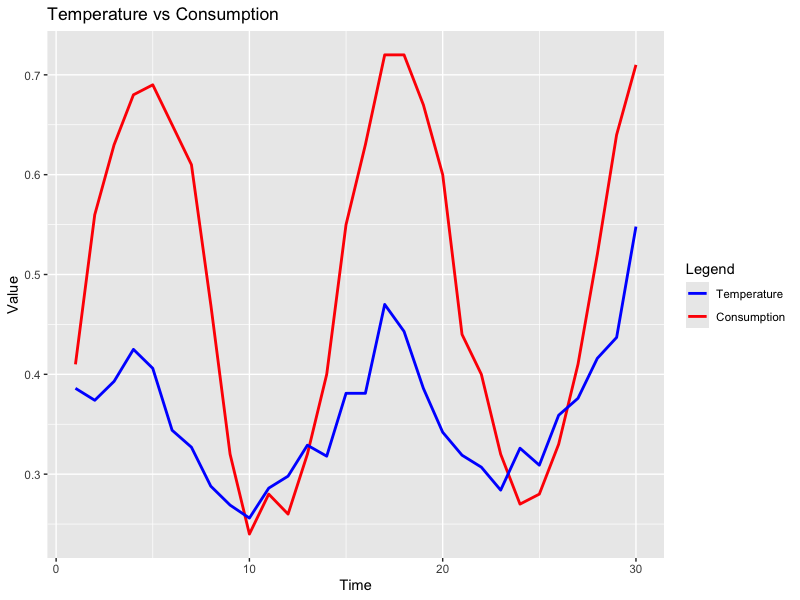

In [50]:
library(ggplot2)
# 假设 icecream 是一个包含 time, temp100（气温），和 consumption（销量）列的数据框

icecream |> 
  ggplot(aes(x = time)) + # 设定x轴为时间
    geom_line(aes(y = temp100, color = "Temperature"), size = 1) + # 气温线
    geom_line(aes(y = consumption, color = "Consumption"), size = 1) + # 销量线
    scale_color_manual(
      name = "Legend", 
      values = c("Temperature" = "red", "Consumption" = "blue"),
      labels = c("Temperature", "Consumption")
    ) + # 自定义图例
    labs(
      title = "Temperature vs Consumption",
      x = "Time",
      y = "Value"
    )

警告信息:
1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 
2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 


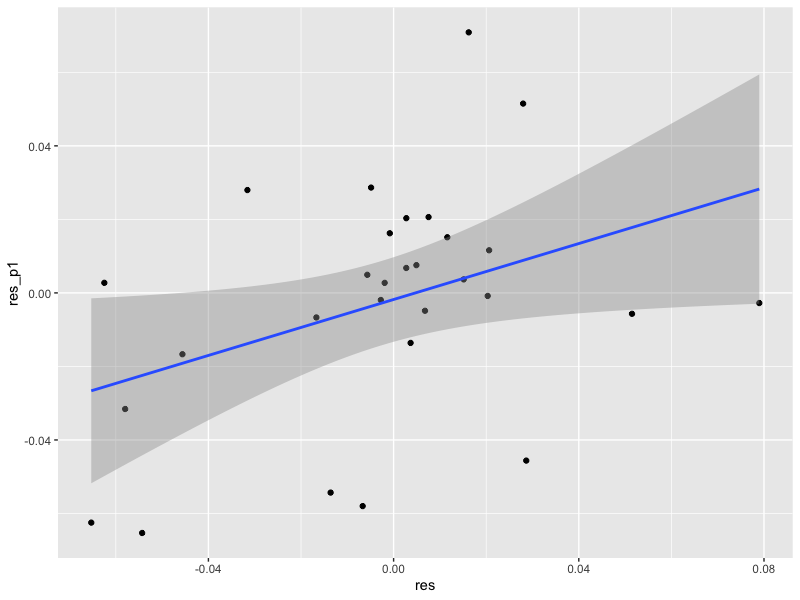

`geom_smooth()` using formula = 'y ~ x'

In [21]:
# 绘制res和res_p1 的散点图
# 先计算残差和残差的滞后性
library(stats)
fit <- lm(consumption ~ price + income + temp, data = icecream)
res <- fit$residuals
res_p1 <- lag(res, n = 1)

# 导入数据并绘图
icecream |> 
  mutate(res = res) |> 
  mutate(res_p1 = res_p1) |> 
  ggplot(aes(x = res, y = res_p1)) +
  geom_point() +
  geom_smooth(method = "lm")

In [24]:
install.packages("forecast")

还安装依赖关系‘fracdiff’, ‘urca’, ‘RcppArmadillo’



试开URL’https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.4/fracdiff_1.5-3.tgz'
Content type 'application/x-gzip' length 127801 bytes (124 KB)
downloaded 124 KB

试开URL’https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.4/urca_1.3-4.tgz'
Content type 'application/x-gzip' length 1109842 bytes (1.1 MB)
downloaded 1.1 MB

试开URL’https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.4/RcppArmadillo_14.2.3-1.tgz'
Content type 'application/x-gzip' length 1667196 bytes (1.6 MB)
downloaded 1.6 MB

试开URL’https://cran.rstudio.com/bin/macosx/big-sur-arm64/contrib/4.4/forecast_8.23.0.tgz'
Content type 'application/x-gzip' length 2493440 bytes (2.4 MB)
downloaded 2.4 MB




下载的二进制程序包在
	/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//RtmpgiHnKr/downloaded_packages里


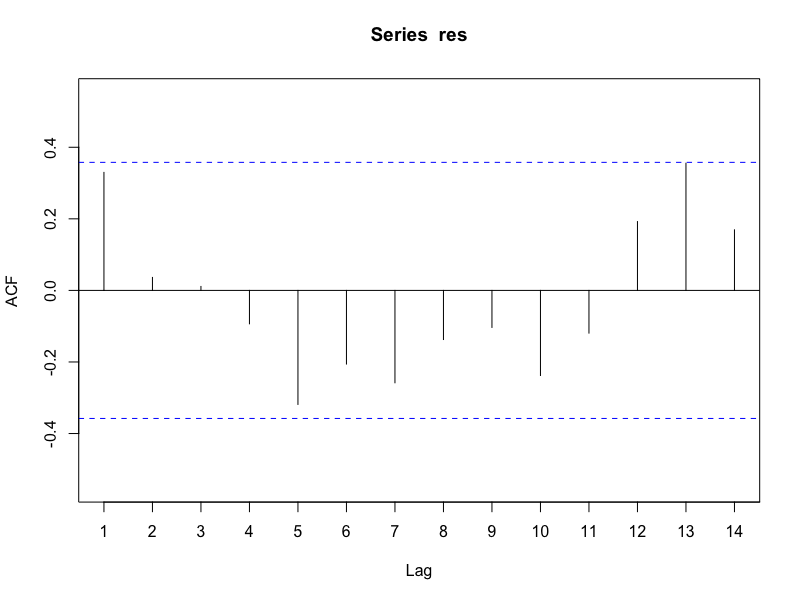

In [54]:
# 绘制自相关图
library(forecast)
Acf(res)

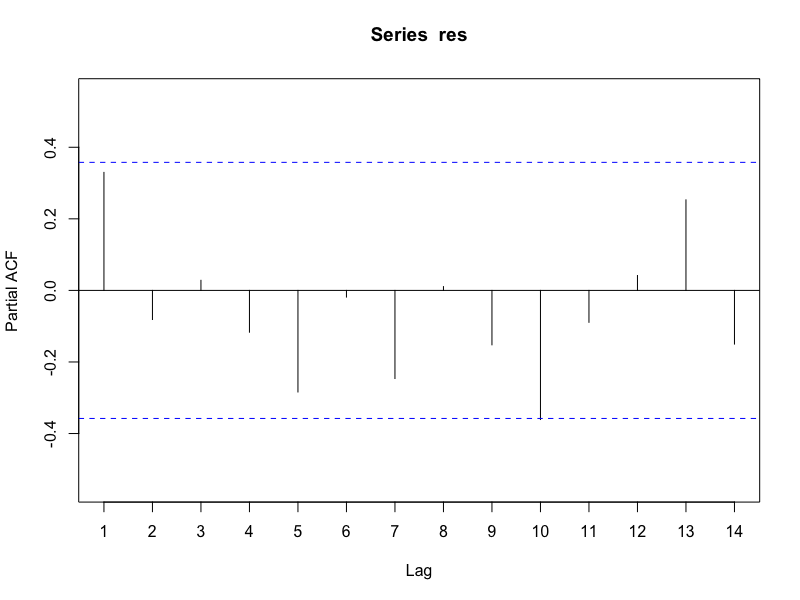

In [52]:
# 绘制偏自相关图
library(forecast)
Pacf(res)

## BG 检验

In [56]:
# 进行BG检验
library(lmtest)
bgtest(fit, order = 1)


	Breusch-Godfrey test for serial correlation of order up to 1

data:  fit
LM test = 4.2371, df = 1, p-value = 0.03955


In [76]:
# 手动构建BG检验
# 普通回归
fit <- lm(consumption ~ price + income + temp, data = icecream)

# 计算残差以及残差滞后项
icecream_bg_test <- icecream |> 
  mutate(
    res = fit$residuals,
    res_p1 = lag(fit$residuals, n = 1) # 根据需要添加滞后项
  )

# 进行辅助回归
fit_bg_test <- lm(
  res ~ price + income + temp + res_p1,  # 根据需要添加滞后项
  data = icecream_bg_test
)
result_bg_test <- summary(fit_bg_test)

# 提取R方和观测数
r2 <- result_bg_test$r.squared
n <- nrow(icecream_bg_test)

# 构建统计量
chi2 <- (n - 1) * r2  # 注意由于滞后性会损失p个样本，这里p=1
print(paste("Chi^2 统计量为：", chi2))

# 指定自由度
df <- 1  # 1是滞后项的数量，这里采用一阶滞后项，根据需要修改
print(paste("自由度为：", df))

# 假设检验
p_value <- 1 - pchisq(chi2, df = df)
print(paste("p值为：", p_value))

[1] "Chi^2 统计量为： 4.70419550674348"
[1] "自由度为： 1"
[1] "p值为： 0.0300890811901878"


In [ ]:
# 手动构建BG检验
# 普通回归
fit <- lm(consumption ~ price + income + temp, data = icecream)

# 计算残差以及残差滞后项
icecream_bg_test <- icecream |> 
  mutate(
    res = fit$residuals,
    res_p1 = lag(fit$residuals, n = 1), # 根据需要添加滞后项
    res_p1 = if_else(is.na(res_p1), 0, res_p1) # 填补缺失数据
  )

# 进行辅助回归
fit_bg_test <- lm(
  res ~ price + income + temp + res_p1,  # 根据需要添加滞后项
  data = icecream_bg_test
)
result_bg_test <- summary(fit_bg_test)

# 提取R方和观测数
r2 <- result_bg_test$r.squared
n <- nrow(icecream_bg_test)

# 构建统计量
chi2 <- n * r2  # 该方法中样本容量没有损失，直接用n就行了
print(paste("Chi^2 统计量为：", chi2))

# 指定自由度
df <- 1  # 1是滞后项的数量，这里采用一阶滞后项，根据需要修改
print(paste("自由度为：", df))

# 假设检验
p_value <- 1 - pchisq(chi2, df = df)
print(paste("p值为：", p_value))

[1] "Chi^2 统计量为： 4.23706877675851"
[1] "自由度为： 1"
[1] "p值为： 0.03955039541603"


## Q检验

先计算Box-Pierce Q 统计量

In [83]:
# Box-Pierce Q 统计量
library(stats)
Box.test(fit$residuals, lag = 1, type = "Box-Pierce")


	Box-Pierce test

data:  fit$residuals
X-squared = 3.2625, df = 1, p-value = 0.07088


In [ ]:
# Box-Ljung Q 统计量
library(stats)
Box.test(fit$residuals, lag = 13, type = "Ljung-Box")


	Box-Ljung test

data:  fit$residuals
X-squared = 26.197, df = 13, p-value = 0.01599


## DW 检验

In [84]:
library(lmtest)
dwtest(fit)


	Durbin-Watson test

data:  fit
DW = 1.0212, p-value = 0.0003024
alternative hypothesis: true autocorrelation is greater than 0


# 处理自相关

## 自相关稳健标准误

In [89]:
# 进行HAC回归
# 先进行普通回归
fit <- lm(consumption ~ price + income + temp, data = icecream)

# 构建HAC标准误
library(sandwich)
HAC <- NeweyWest(fit, lag = 3)

# 进行系数检验
library(lmtest)
coeftest(fit, vcov = HAC)


t test of coefficients:

               Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)  0.19731489  0.33503035  0.5889  0.560980    
price       -1.04441312  0.99293930 -1.0518  0.302551    
income       0.00330776  0.00098235  3.3672  0.002373 ** 
temp         0.00345843  0.00051366  6.7329 3.821e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [90]:
library(lmtest)
waldtest(fit, vcov = HAC)

Wald test

Model 1: consumption ~ price + income + temp
Model 2: consumption ~ 1
  Res.Df Df      F    Pr(>F)    
1     26                        
2     29 -3 20.023 6.191e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## FGLS

In [106]:
icecream

# A tibble: 30 × 6
    time consumption price income  temp temp100
   <dbl>       <dbl> <dbl>  <dbl> <dbl>   <dbl>
 1     1       0.386 0.270     78    41   0.410
 2     2       0.374 0.282     79    56   0.560
 3     3       0.393 0.277     81    63   0.630
 4     4       0.425 0.280     80    68   0.680
 5     5       0.406 0.272     76    69   0.690
 6     6       0.344 0.262     78    65   0.650
 7     7       0.327 0.275     82    61   0.610
 8     8       0.288 0.267     79    47   0.470
 9     9       0.269 0.265     76    32   0.320
10    10       0.256 0.277     79    24   0.240
# ℹ 20 more rows
# ℹ Use `print(n = ...)` to see more rows

In [119]:
# Prais-Winsten 估计法
# 基础回归
fit <- lm(consumption ~ price + income + temp, data = icecream)

# 获取残差
library(stats)
icecream_FGLS <- icecream |> 
  mutate(
    res = fit$residuals,
    res_1p = if_else(
      row_number() == 1,
      0,
      lag(res)
    )
  )

# 估计相关系数
fit_rho <- lm(res ~ res_1p-1, data = icecream_FGLS)
rho <- fit_rho$coefficients

# 迭代求解rho系数
n = 1000  # 设置迭代次数
eps = 0.0000000001  # 设置迭代停止条件，rho之差稳定
rho_circle = 0  # 用于暂存迭代的rho
for (i in 1:n) {
  # 记录首个值，方便后续构造数据集
  consumption_1 <- icecream_FGLS$consumption[1]
  price_1 <- icecream_FGLS$price[1]
  income_1 <- icecream_FGLS$income[1]
  temp_1 <- icecream_FGLS$temp[1]

  # 构造数据集
  icecream_FGLS <- icecream_FGLS |> 
    mutate(
      consumption_trans = if_else(
        row_number() == 1,
        sqrt(1 - rho^2) * consumption_1,
        consumption - rho * lag(consumption)
      ),

      cons = if_else(
        row_number() == 1,
        sqrt(1 - rho^2),
        1 - rho
      ),

      price_trans = if_else(
        row_number() == 1,
        sqrt(1 - rho^2) * price_1,
        price - rho * lag(price)
      ),

      income_trans = if_else(
        row_number() == 1,
        sqrt(1 - rho^2) * income_1,
        income - rho * lag(income)
      ),

      temp_trans = if_else(
        row_number() == 1,
        sqrt(1 - rho^2) * temp_1,
        temp - rho * lag(temp)
      )
    )
  
  # 进行回归
  fit_FGLS <- lm(
    consumption_trans ~ cons + price_trans + income_trans + temp_trans -1, # 不要常数项
    data = icecream_FGLS
  )

  # 获取残差
  icecream_FGLS <- icecream_FGLS |> 
    mutate(
      res = fit_FGLS$residuals,
      res_1p = if_else(
        row_number() == 1,
        0,
        lag(res)
      )
    )

  # 估计相关系数
  fit_rho <- lm(res ~ res_1p-1, data = icecream_FGLS)
  rho_circle <- fit_rho$coefficients

  # 检测是否达到收敛条件
  if (abs(rho - rho_circle) < eps) {
    print("已经收敛")
    print(paste("迭代次数为：", i))
    rho <- rho_circle
    break
  }

  # 没有收敛，则继续迭代
  rho <- rho_circle
}

# 汇报结果
summary(fit_FGLS)

[1] "已经收敛"
[1] "迭代次数为： 58"



Call:
lm(formula = consumption_trans ~ cons + price_trans + income_trans + 
    temp_trans - 1, data = icecream_FGLS)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.067147 -0.008751  0.000879  0.011393  0.080187 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
cons          0.2737891  0.2801563   0.977    0.337    
price_trans  -1.1519851  0.8417050  -1.369    0.183    
income_trans  0.0028112  0.0013483   2.085    0.047 *  
temp_trans    0.0033908  0.0005073   6.684 4.32e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03445 on 26 degrees of freedom
Multiple R-squared:  0.9872,	Adjusted R-squared:  0.9852 
F-statistic: 499.7 on 4 and 26 DF,  p-value: < 2.2e-16


In [121]:
# 加载必要的库
library(dplyr)
library(stats)

# 假设您的数据框名为 icecream，包含 consumption、price、income 和 temp 变量
# 基础回归
fit <- lm(consumption ~ price + income + temp, data = icecream)

# 获取残差
icecream_FGLS <- icecream %>%
  mutate(
    res = fit$residuals,
    res_1p = lag(res, default = 0)
  )

# 估计相关系数
fit_rho <- lm(res ~ res_1p - 1, data = icecream_FGLS)
rho <- fit_rho$coefficients

# 迭代求解 rho 系数
n <- 1000  # 设置迭代次数
eps <- 1e-10  # 设置迭代停止条件，rho 之差稳定
rho_circle <- 0  # 用于暂存迭代的 rho

for (i in 1:n) {
  # 记录首个值，方便后续构造数据集
  consumption_1 <- icecream_FGLS$consumption[1]
  price_1 <- icecream_FGLS$price[1]
  income_1 <- icecream_FGLS$income[1]
  temp_1 <- icecream_FGLS$temp[1]

  # 构造数据集
  icecream_FGLS <- icecream_FGLS %>%
    mutate(
      consumption_trans = if_else(
        row_number() == 1,
        sqrt(1 - rho^2) * consumption_1,
        consumption - rho * lag(consumption)
      ),
      cons = if_else(
        row_number() == 1,
        sqrt(1 - rho^2),
        1 - rho
      ),
      price_trans = if_else(
        row_number() == 1,
        sqrt(1 - rho^2) * price_1,
        price - rho * lag(price)
      ),
      income_trans = if_else(
        row_number() == 1,
        sqrt(1 - rho^2) * income_1,
        income - rho * lag(income)
      ),
      temp_trans = if_else(
        row_number() == 1,
        sqrt(1 - rho^2) * temp_1,
        temp - rho * lag(temp)
      )
    )

  # 进行回归
  fit_FGLS <- lm(
    consumption_trans ~ cons + price_trans + income_trans + temp_trans - 1, # 不要常数项
    data = icecream_FGLS
  )

  # 获取残差
  icecream_FGLS <- icecream_FGLS %>%
    mutate(
      res = fit_FGLS$residuals,
      res_1p = lag(res, default = 0)
    )

  # 估计相关系数
  fit_rho <- lm(res ~ res_1p - 1, data = icecream_FGLS)
  rho_circle <- fit_rho$coefficients

  # 检测是否达到收敛条件
  if (abs(rho - rho_circle) < eps) {
    print("已经收敛")
    print(paste("迭代次数为：", i))
    rho <- rho_circle
    break
  }

  # 没有收敛，则继续迭代
  rho <- rho_circle
}

# 汇报结果
summary(fit_FGLS)

[1] "已经收敛"
[1] "迭代次数为： 58"



Call:
lm(formula = consumption_trans ~ cons + price_trans + income_trans + 
    temp_trans - 1, data = icecream_FGLS)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.067147 -0.008751  0.000879  0.011393  0.080187 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
cons          0.2737891  0.2801563   0.977    0.337    
price_trans  -1.1519851  0.8417050  -1.369    0.183    
income_trans  0.0028112  0.0013483   2.085    0.047 *  
temp_trans    0.0033908  0.0005073   6.684 4.32e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03445 on 26 degrees of freedom
Multiple R-squared:  0.9872,	Adjusted R-squared:  0.9852 
F-statistic: 499.7 on 4 and 26 DF,  p-value: < 2.2e-16


In [104]:
# 加载必要的包
library(prais)

# 假设 icecream 数据已加载，并且包含 consumption, price, income, temp 列
# 查看数据结构以确认列名
str(icecream)

# 使用 prais_winsten 函数进行 Prais-Winsten 估计
# 注意：确保数据框中有一个时间序列索引列（例如 year 或者 time）
# 如果没有，您可能需要先创建一个或者指定一个现有的作为 index 参数

# 示例模型：consumption 对 price, income 和 temp 的回归
pw_result <- prais_winsten(
  consumption ~ price + income + temp,
  data = icecream,
  index = "time"
)

# 打印结果
print(pw_result)

tibble [30 × 6] (S3: tbl_df/tbl/data.frame)
 $ time       : num [1:30] 1 2 3 4 5 6 7 8 9 10 ...
  ..- attr(*, "format.stata")= chr "%9.0g"
 $ consumption: num [1:30] 0.386 0.374 0.393 0.425 0.406 ...
  ..- attr(*, "format.stata")= chr "%9.0g"
 $ price      : num [1:30] 0.27 0.282 0.277 0.28 0.272 ...
  ..- attr(*, "format.stata")= chr "%9.0g"
 $ income     : num [1:30] 78 79 81 80 76 78 82 79 76 79 ...
  ..- attr(*, "format.stata")= chr "%9.0g"
 $ temp       : num [1:30] 41 56 63 68 69 65 61 47 32 24 ...
  ..- attr(*, "format.stata")= chr "%9.0g"
 $ temp100    : num [1:30] 0.41 0.56 0.63 0.68 0.69 ...
  ..- attr(*, "label")= chr "temp/100"
  ..- attr(*, "format.stata")= chr "%9.0g"
Iteration 0: rho = 0
Iteration 1: rho = 0.4006
Iteration 2: rho = 0.4982
Iteration 3: rho = 0.5553
Iteration 4: rho = 0.5972
Iteration 5: rho = 0.6315
Iteration 6: rho = 0.661
Iteration 7: rho = 0.6867
Iteration 8: rho = 0.7092
Iteration 9: rho = 0.7286
Iteration 10: rho = 0.7448
Iteration 11: rho = 0.7581
I

In [105]:
summary(pw_result)


Call:
prais_winsten(formula = consumption ~ price + income + temp, 
    data = icecream, index = "time")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09764 -0.03683 -0.01942  0.01409  0.09616 

AR(1) coefficient rho after 41 iterations: 0.8002

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.5870049  0.2952699   1.988 0.057434 .  
price       -1.0488545  0.7597510  -1.381 0.179179    
income      -0.0008022  0.0020458  -0.392 0.698148    
temp         0.0029541  0.0007109   4.156 0.000311 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03232 on 26 degrees of freedom
Multiple R-squared:  0.6234,	Adjusted R-squared:  0.5799 
F-statistic: 14.35 on 3 and 26 DF,  p-value: 1.035e-05

Durbin-Watson statistic (original): 1.021 
Durbin-Watson statistic (transformed): 1.847


In [103]:
icecream

# A tibble: 30 × 6
    time consumption price income  temp temp100
   <dbl>       <dbl> <dbl>  <dbl> <dbl>   <dbl>
 1     1       0.386 0.270     78    41   0.410
 2     2       0.374 0.282     79    56   0.560
 3     3       0.393 0.277     81    63   0.630
 4     4       0.425 0.280     80    68   0.680
 5     5       0.406 0.272     76    69   0.690
 6     6       0.344 0.262     78    65   0.650
 7     7       0.327 0.275     82    61   0.610
 8     8       0.288 0.267     79    47   0.470
 9     9       0.269 0.265     76    32   0.320
10    10       0.256 0.277     79    24   0.240
# ℹ 20 more rows
# ℹ Use `print(n = ...)` to see more rows

In [125]:
# 查看 prais_winsten 函数的源代码
prais:::prais_winsten

function (formula, data, index, max_iter = 50L, tol = 1e-06, 
    twostep = FALSE, panelwise = FALSE, rhoweight = c("none", 
        "T", "T1"), ...) 
{
    cl <- match.call()
    rhoweight <- match.arg(rhoweight)
    data <- as.data.frame(data)
    panel <- FALSE
    if (!is.null(index)) {
        if (length(index) > 2) {
            stop("Argument 'index' can only have up to 2 elements.")
        }
        if (length(index) == 2) {
            panel <- TRUE
        }
        else {
            panelwise <- FALSE
        }
    }
    if (length(index) == 1) {
        data <- data[order(data[, index]), ]
    }
    if (panel) {
        data <- data[order(data[, index[1]]), ]
        data <- data[order(data[, index[2]]), ]
        group_names <- unique(data[, index[1]])
        n_groups <- length(group_names)
        groups <- c()
        for (i in 1:n_groups) {
            pos_temp <- which(data[, index[1]] == group_names[i])
            names(pos_temp) <- NULL
            groups <- c(gr

In [129]:
library(dplyr)

# 基础回归
fit <- lm(consumption ~ price + income + temp, data = icecream)

# 获取残差
icecream_FGLS <- icecream |> 
  mutate(
    res = residuals(fit),
    res_1p = lag(res, default = 0)  # 使用默认值处理NA
  )

# 估计初始相关系数
fit_rho <- lm(res ~ res_1p - 1, data = icecream_FGLS)
rho <- coef(fit_rho)

# 迭代求解rho系数
n = 50  # 设置迭代次数
tol = 1e-6  # 设置迭代停止条件，rho之差稳定
for (i in 1:n) {
  rho_old <- rho
  
  # 记录首个值，方便后续构造数据集
  consumption_1 <- icecream$consumption[1]
  price_1 <- icecream$price[1]
  income_1 <- icecream$income[1]
  temp_1 <- icecream$temp[1]

  # 构造数据集
  icecream_transformed <- icecream_FGLS |> 
    mutate(
      consumption_trans = if_else(row_number() == 1,
                                  sqrt(1 - rho^2) * consumption_1,
                                  consumption - rho * lag(consumption, default = 0)),
      
      cons = if_else(row_number() == 1,
                     sqrt(1 - rho^2),
                     1 - rho),

      price_trans = if_else(row_number() == 1,
                            sqrt(1 - rho^2) * price_1,
                            price - rho * lag(price, default = 0)),
      
      income_trans = if_else(row_number() == 1,
                             sqrt(1 - rho^2) * income_1,
                             income - rho * lag(income, default = 0)),
      
      temp_trans = if_else(row_number() == 1,
                           sqrt(1 - rho^2) * temp_1,
                           temp - rho * lag(temp, default = 0))
    )
  
  # 进行回归
  fit_FGLS <- lm(consumption_trans ~ cons + price_trans + income_trans + temp_trans -1, 
                 data = icecream_transformed)

  # 更新残差
  icecream_FGLS <- icecream_transformed |> 
    mutate(
      res = residuals(fit_FGLS),
      res_1p = lag(res, default = 0)
    )

  # 估计相关系数
  fit_rho <- lm(res ~ res_1p - 1, data = icecream_FGLS)
  rho_new <- coef(fit_rho)

  # 检测是否达到收敛条件
  if (abs(rho - rho_new) < tol) {
    print("已经收敛")
    print(paste("迭代次数为：", i))
    rho <- rho_new
    break
  }

  # 更新rho值
  rho <- rho_new
}

# 汇报结果
summary(fit_FGLS)

[1] "已经收敛"
[1] "迭代次数为： 34"



Call:
lm(formula = consumption_trans ~ cons + price_trans + income_trans + 
    temp_trans - 1, data = icecream_transformed)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.067147 -0.008751  0.000879  0.011393  0.080187 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
cons          0.2737889  0.2801563   0.977    0.337    
price_trans  -1.1519850  0.8417050  -1.369    0.183    
income_trans  0.0028112  0.0013483   2.085    0.047 *  
temp_trans    0.0033908  0.0005073   6.684 4.32e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03445 on 26 degrees of freedom
Multiple R-squared:  0.9872,	Adjusted R-squared:  0.9852 
F-statistic: 499.7 on 4 and 26 DF,  p-value: < 2.2e-16


In [130]:
# Prais-Winsten 估计法
library(prais)

pw_result <- prais_winsten(
  consumption ~ price + income + temp,
  data = icecream,
  index = "time"
)

summary(pw_result)

Iteration 0: rho = 0
Iteration 1: rho = 0.4006
Iteration 2: rho = 0.4982
Iteration 3: rho = 0.5553
Iteration 4: rho = 0.5972
Iteration 5: rho = 0.6315
Iteration 6: rho = 0.661
Iteration 7: rho = 0.6867
Iteration 8: rho = 0.7092
Iteration 9: rho = 0.7286
Iteration 10: rho = 0.7448
Iteration 11: rho = 0.7581
Iteration 12: rho = 0.7686
Iteration 13: rho = 0.7768
Iteration 14: rho = 0.783
Iteration 15: rho = 0.7877
Iteration 16: rho = 0.7911
Iteration 17: rho = 0.7936
Iteration 18: rho = 0.7955
Iteration 19: rho = 0.7968
Iteration 20: rho = 0.7978
Iteration 21: rho = 0.7985
Iteration 22: rho = 0.799
Iteration 23: rho = 0.7993
Iteration 24: rho = 0.7996
Iteration 25: rho = 0.7998
Iteration 26: rho = 0.7999
Iteration 27: rho = 0.8
Iteration 28: rho = 0.8001
Iteration 29: rho = 0.8001
Iteration 30: rho = 0.8001
Iteration 31: rho = 0.8002
Iteration 32: rho = 0.8002
Iteration 33: rho = 0.8002
Iteration 34: rho = 0.8002
Iteration 35: rho = 0.8002
Iteration 36: rho = 0.8002
Iteration 37: rho = 0.


Call:
prais_winsten(formula = consumption ~ price + income + temp, 
    data = icecream, index = "time")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.09764 -0.03683 -0.01942  0.01409  0.09616 

AR(1) coefficient rho after 41 iterations: 0.8002

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.5870049  0.2952699   1.988 0.057434 .  
price       -1.0488545  0.7597510  -1.381 0.179179    
income      -0.0008022  0.0020458  -0.392 0.698148    
temp         0.0029541  0.0007109   4.156 0.000311 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03232 on 26 degrees of freedom
Multiple R-squared:  0.6234,	Adjusted R-squared:  0.5799 
F-statistic: 14.35 on 3 and 26 DF,  p-value: 1.035e-05

Durbin-Watson statistic (original): 1.021 
Durbin-Watson statistic (transformed): 1.847


In [133]:
help("prais")

In [134]:
install.packages("orcutt")

警告信息:
package ‘orcutt’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages 
